In [26]:
import pandas as pd
import random
import time
from functools import wraps
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:

# Danh sách hãng
Name = [
    'HP', 'Lenovo', 'Samsung', 'Tecno', 'Xiaomi', 'Dell', 'Asus',
    'Wings', 'Apple', 'Zebronics', 'Gigabyte', 'Acer', 'MSI',
    'Infinix', 'Honor', 'Colorful', 'iBall', 'Walker', 'Chuwi', 'ASUS',
    'Ultimus', 'Jio', 'Microsoft', 'Primebook', 'Ninkear', 'Avita',
    'Huawei', 'Fujitsu', 'LG', 'Razer', 'AXL'
]

# Khoảng giá trị
Price = [8_000, 600_000]
Sold = [5_000, 500_000]
Rating = [1.0, 5.0]

In [3]:
def create_dataset(length_dataset=10_000):
    data = []
    for i in range(length_dataset):
        product = {
            "id": i + 1,
            "name": random.choice(Name),
            "price": random.randint(Price[0], Price[1]),
            "sold": random.randint(Sold[0], Sold[1]),
            "rating": round(random.uniform(Rating[0], Rating[1]), 2)
        }
        data.append(product)
    
    dataset = pd.DataFrame(data)
  
    return dataset

df = create_dataset()
df_test = df[:10]
df.head()

,id,name,price,sold,rating
0,1,Huawei,170516,133754,1.25
1,2,Wings,530244,147741,1.42
2,3,Razer,540035,338358,2.58
3,4,Fujitsu,183041,244929,4.65
4,5,Wings,454840,192420,1.64


In [4]:
class Search:
    def __init__(self, dataset: pd.DataFrame):
        self.dataset = dataset.copy()

    def validate_type_search(self, search_type: str):
        if search_type not in self.dataset.columns:
            raise ValueError(
                f"[Error]: Cột '{search_type}' không tồn tại trong dataset. "
                f"Các cột hiện có: {list(self.dataset.columns)}"
            )

    def linear_search(self, search_type: str, value):
        self.validate_type_search(search_type)
        for i in range(len(self.dataset)):
            if self.dataset.iloc[i][search_type] == value:
                return self.dataset.iloc[i]
        return None

    def binary_search(self, search_type: str, value):
        self.validate_type_search(search_type)
        
        left, right = 0, len(self.dataset) - 1 

        while left <= right:
            mid = (left + right) // 2
            mid_value = self.dataset.iloc[mid][search_type]

            if mid_value == value:
                return self.dataset.iloc[mid]
            elif mid_value < value:
                left = mid + 1
            else:
                right = mid - 1
        return None

In [5]:
class Sort:
    def __init__(self, dataset: pd.DataFrame, copy_data: bool = True):
        if copy_data:
            self.dataset = dataset.copy()
        else:
            self.dataset = dataset
            print("[Warning]: Đang làm việc trên dataset gốc. Các thay đổi sẽ làm thay đổi DataFrame đầu vào..") 
        
        self.type_sort_list = ["name", "price", "id", "sold", "rating"]  
        self._update_internal_state()
    
    def _update_internal_state(self):
        self.records = self.dataset.to_dict('records')
        self.n = len(self.records)
    
    def _validate_sort_type(self, sort_type: str):
        """Kiểm tra sự tồn tại của cột"""
        if sort_type not in self.type_sort_list:
            raise ValueError(f"[Error] Loại sắp xếp '{sort_type}' không hợp lệ. Chỉ hỗ trợ: {self.type_sort_list}")

    def _utils(func):
        @wraps(func)
        def wrapper(self, sort_type, *args, **kwargs):
            self._validate_sort_type(sort_type)
            self.current_sort_column = sort_type  # Theo dõi cột đang được sắp xếp
            self._update_internal_state()  
            start_time = time.time()
            result = func(self, sort_type, *args, **kwargs)
            elapse_time = time.time() - start_time                
            return result, elapse_time
        return wrapper
    
    def _get_comparable_value(self, value, sort_type):
        """
        - Xử lý giá trị None
        - Kiểm tra an toàn kiểu dữ liệu
        - Chuẩn hóa dữ liệu để so sánh
        """
        # Xử lý giá trị None - đặt None ở cuối khi sắp xếp
        if value is None or pd.isna(value):
            return float('inf')  # None sẽ luôn lớn nhất
        
        # Kiểm tra an toàn kiểu và xử lý theo từng loại dữ liệu
        if sort_type == "name":
            if isinstance(value, str):
                return value.lower().strip()  # chuyển về chữ thường và loại bỏ khoảng trắng đầu/cuối
            else:
                # Chuyển giá trị không phải chuỗi thành chuỗi để so sánh tên
                return str(value).lower().strip()
        
        elif sort_type in ["price", "sold", "rating"]:
            # Đảm bảo kiểu số
            try:
                if isinstance(value, (int, float)):
                    return float(value)
                elif isinstance(value, str):
                    # Thử chuyển chuỗi thành số
                    cleaned_value = value.replace(',', '').replace('', '').strip()
                    return float(cleaned_value)
                else:
                    return float(value)
            except (ValueError, TypeError):
                # Nếu chuyển đổi thất bại, coi như vô cực (đưa xuống cuối)
                return float('inf')
        
        elif sort_type == "id":
            # ID có thể là số hoặc chuỗi
            try:
                if isinstance(value, (int, float)):
                    return int(value)
                elif isinstance(value, str):
                    # Ưu tiên chuyển thành số trước
                    try:
                        return int(value)
                    except ValueError:
                        # Nếu không phải số, so sánh như chuỗi
                        return value.lower().strip()
                else:
                    return str(value).lower().strip()
            except (ValueError, TypeError):
                return float('inf')
        
        # Trường hợp mặc định - trả về nguyên giá trị cho các loại khác
        return value


In [6]:
class ElementSort(Sort):
    def __init__(self, dataset, copy_data = True):
        super().__init__(dataset, copy_data)

    @Sort._utils
    def interchange_sort(self, sort_type: str, ascending: bool = True):
        # Sắp xếp đổi chỗ (Interchange sort)
        for i in range(self.n):
            for j in range(i + 1, self.n):
                val_i = self._get_comparable_value(self.records[i][sort_type], sort_type)
                val_j = self._get_comparable_value(self.records[j][sort_type], sort_type)
                should_swap = (val_i > val_j) if ascending else (val_i < val_j)
                if should_swap:
                    self.records[i], self.records[j] = self.records[j], self.records[i]
        
        # Cập nhật lại dataset
        self.dataset = pd.DataFrame(self.records)
        return self.dataset

    @Sort._utils
    def bubble_sort(self, sort_type: str, ascending: bool = True):
        for i in range(self.n):
            swapped = False
            for j in range(0, self.n - i - 1):
                val1 = self._get_comparable_value(self.records[j][sort_type], sort_type)
                val2 = self._get_comparable_value(self.records[j + 1][sort_type], sort_type)

                should_swap = (val1 > val2) if ascending else (val1 < val2)
                if should_swap:
                    self.records[j], self.records[j + 1] = self.records[j + 1], self.records[j]
                    swapped = True
            if not swapped:
                break
        
        self.dataset = pd.DataFrame(self.records)
        return self.dataset
    
    @Sort._utils
    def selection_sort(self, sort_type: str, ascending: bool = True):
        for i in range(self.n):
            # Giả sử phần tử tại i là cực trị
            target_idx = i
            for j in range(i + 1, self.n):
                val_target = self._get_comparable_value(self.records[target_idx][sort_type], sort_type)
                val_j = self._get_comparable_value(self.records[j][sort_type], sort_type)
                # So sánh theo thứ tự tăng/giảm dần
                should_update = (val_j < val_target) if ascending else (val_j > val_target)
                if should_update:
                    target_idx = j
            # Hoán đổi phần tử tại i và target_idx
            if target_idx != i:
                self.records[i], self.records[target_idx] = self.records[target_idx], self.records[i]
        self.dataset = pd.DataFrame(self.records)
        return self.dataset
    
    @Sort._utils
    def insertion_sort(self, sort_type: str, ascending: bool = True):
        for i in range(1, self.n):
            key_record = self.records[i]
            key_value = self._get_comparable_value(key_record[sort_type], sort_type)
            j = i - 1
            # Di chuyển các phần tử lớn hơn (hoặc nhỏ hơn nếu descending) sang phải
            while j >= 0:
                compare_val = self._get_comparable_value(self.records[j][sort_type], sort_type)
                should_shift = (compare_val > key_value) if ascending else (compare_val < key_value)
                if should_shift:
                    self.records[j + 1] = self.records[j]
                    j -= 1
                else:
                    break
            # Chèn phần tử vào vị trí đúng
            self.records[j + 1] = key_record
        self.dataset = pd.DataFrame(self.records)
        return self.dataset

In [7]:
class DivideConquerSorting(Sort):
    def __init__(self, dataset, copy_data = True):
        super().__init__(dataset, copy_data)

    @Sort._utils
    def merge_sort(self, sort_type: str, ascending: bool = True):
        def _merge(left, right, sort_type, ascending):
            merged = []
            i = j = 0
            while i < len(left) and j < len(right):
                val_i = self._get_comparable_value(left[i][sort_type], sort_type)
                val_j = self._get_comparable_value(right[j][sort_type], sort_type)
                if ascending:
                    if val_i <= val_j:
                        merged.append(left[i])
                        i += 1
                    else:
                        merged.append(right[j])
                        j += 1
                else:
                    if val_i >= val_j:
                        merged.append(left[i])
                        i += 1
                    else:
                        merged.append(right[j])
                        j += 1
            # Thêm phần còn lại
            merged.extend(left[i:])
            merged.extend(right[j:])
            return merged
        
        def _merge_sort_recursive(records, sort_type, ascending):
            if len(records) <= 1:
                return records
            mid = len(records) // 2
            left = _merge_sort_recursive(records[:mid], sort_type, ascending)
            right = _merge_sort_recursive(records[mid:], sort_type, ascending)
            return _merge(left, right, sort_type, ascending)
        
        # Thực hiện sắp xếp
        self.records = _merge_sort_recursive(self.records, sort_type, ascending)
        self.dataset = pd.DataFrame(self.records)
        return self.dataset
    
    @Sort._utils  
    def quick_sort(self, sort_type: str, ascending: bool = True):
        def _partition(records, low, high, sort_type, ascending):
            pivot_record = records[high]
            pivot_val = self._get_comparable_value(pivot_record[sort_type], sort_type)
            i = low - 1
            for j in range(low, high):
                val_j = self._get_comparable_value(records[j][sort_type], sort_type)
                should_swap = (val_j <= pivot_val) if ascending else (val_j >= pivot_val)
                if should_swap:
                    i += 1
                    records[i], records[j] = records[j], records[i]
            records[i + 1], records[high] = records[high], records[i + 1]
            return i + 1
        
        def _quick_sort_recursive(records, low, high, sort_type, ascending):
            if low < high:
                pi = _partition(records, low, high, sort_type, ascending)
                _quick_sort_recursive(records, low, pi - 1, sort_type, ascending)
                _quick_sort_recursive(records, pi + 1, high, sort_type, ascending)

        if self.n > 0:
            _quick_sort_recursive(self.records, 0, self.n - 1, sort_type, ascending)
        
        self.dataset = pd.DataFrame(self.records)
        return self.dataset

In [8]:
class NonComparisonSort(Sort):
    def __init__(self, dataset, copy_data=True):
        super().__init__(dataset, copy_data)

    @Sort._utils
    def counting_sort(self, sort_type: str, ascending: bool = True):
        if sort_type not in ["id", "sold", "price"]:
            raise ValueError("Counting Sort chỉ hỗ trợ 'id', 'sold', 'price' (số nguyên >= 0)")
        if self.n == 0:
            return self.dataset

        values = []
        for record in self.records:
            val = record[sort_type]
            try:
                int_val = int(float(val)) if not pd.isna(val) else 0
                values.append(int_val)
            except (ValueError, TypeError):
                raise ValueError(f"Giá trị '{val}' không phải số nguyên hợp lệ")

        min_val, max_val = min(values), max(values)
        range_size = max_val - min_val + 1
        density = self.n / range_size

        # Dense counting sort
        buckets = [[] for _ in range(range_size)]
        for i, val in enumerate(values):
            buckets[val - min_val].append(self.records[i])

        iteration = range(range_size) if ascending else range(range_size - 1, -1, -1)
        self.records = [rec for idx in iteration for rec in buckets[idx]]
        self.dataset = pd.DataFrame(self.records)
        return self.dataset

    @Sort._utils
    def radix_sort(self, sort_type: str, ascending: bool = True):
        if sort_type not in ["id", "sold", "price"]:
            raise ValueError("Radix Sort chỉ hỗ trợ 'id', 'sold', 'price'")
        if self.n == 0:
            return self.dataset

        indexed = []
        for rec in self.records:
            val = rec[sort_type]
            try:
                int_val = int(float(val)) if not pd.isna(val) else 0
                indexed.append((int_val, rec))
            except (ValueError, TypeError):
                raise ValueError(f"Giá trị '{val}' không hợp lệ cho Radix Sort")

        neg = [(v, r) for v, r in indexed if v < 0]
        pos = [(v, r) for v, r in indexed if v >= 0]

        def _radix_sort_positive(data):
            if not data:
                return data
            max_val = max(v for v, _ in data)
            base = 10
            passes = 0
            temp = max_val
            while temp:
                temp //= base
                passes += 1

            current = data
            for p in range(passes):
                buckets = [[] for _ in range(base)]
                for val, rec in current:
                    digit = (val // (base ** p)) % base
                    buckets[digit].append((val, rec))
                current = [item for bucket in buckets for item in bucket]
            return current

        pos = _radix_sort_positive(pos)
        if neg:
            neg_pos = [(-v, r) for v, r in neg]
            neg_sorted = _radix_sort_positive(neg_pos)
            neg = [(-v, r) for v, r in reversed(neg_sorted)]

        final = (neg + pos) if ascending else (list(reversed(pos)) + list(reversed(neg)))
        self.records = [r for _, r in final]
        self.dataset = pd.DataFrame(self.records)
        return self.dataset

In [ ]:
# List toàn cục lưu kết quả benchmark
benchmark_results = []

def run_benchmark_one_algorithm(algo_name, algo_func, df, repeat=5):
    sort_types = ["name", "price", "sold", "rating"]

    for sort_type in sort_types:
        times = []
        try:
            for _ in range(repeat):
                sorter = algo_func.__self__.__class__(df)  # reset dataset
                _, elapsed = algo_func.__get__(sorter)(sort_type=sort_type, ascending=True)
                times.append(elapsed)
            avg_time = mean(times)
        except Exception:
            avg_time = None
            
        benchmark_results.append((algo_name, sort_type, avg_time))


In [12]:
def check_stability(dataset, sort_type="price"):
    # Tạo dữ liệu nhỏ (10–20 bản ghi)
    df = dataset.sample(15, random_state=42).reset_index(drop=True)

    # Đánh số thứ tự ban đầu
    df["orig_idx"] = df.index

    # Danh sách thuật toán cần kiểm tra
    algorithms = {
        "Bubble Sort": ElementSort(df, copy_data=True).bubble_sort,
        "Insertion Sort": ElementSort(df, copy_data=True).insertion_sort,
        "Selection Sort": ElementSort(df, copy_data=True).selection_sort,
        "Interchange Sort": ElementSort(df, copy_data=True).interchange_sort,
        "Merge Sort": DivideConquerSorting(df, copy_data=True).merge_sort,
        "Quick Sort": DivideConquerSorting(df, copy_data=True).quick_sort,
        "Counting Sort": NonComparisonSort(df, copy_data=True).counting_sort,
        "Radix Sort": NonComparisonSort(df, copy_data=True).radix_sort,
    }

    results = []

    for name, algo in algorithms.items():
        try:
            sorter = algo.__self__.__class__(df, copy_data=True)
            sorted_df, _ = algo.__get__(sorter)(sort_type=sort_type, ascending=True)

            # Lấy các nhóm có cùng giá trị khóa
            stable = True
            for _, group in sorted_df.groupby(sort_type):
                orig_order = group["orig_idx"].tolist()
                if orig_order != sorted(orig_order):
                    stable = False
                    break

            results.append((name, "Ổn định" if stable else "Không ổn định"))

        except Exception as e:
            results.append((name, f"Lỗi: {e}"))

    return pd.DataFrame(results, columns=["Thuật toán", "Kết quả"])

stability_results = check_stability(df, sort_type="price")


In [11]:
stability_results

,Thuật toán,Kết quả
0,Bubble Sort,Ổn định
1,Insertion Sort,Ổn định
2,Selection Sort,Ổn định
3,Interchange Sort,Ổn định
4,Merge Sort,Ổn định
5,Quick Sort,Ổn định
6,Counting Sort,Ổn định
7,Radix Sort,Ổn định


In [ ]:
# Bubble Sort
run_benchmark_one_algorithm(
    "Bubble Sort",
    ElementSort(df, copy_data=True).bubble_sort,
    df
)

# Insertion Sort
run_benchmark_one_algorithm(
    "Insertion Sort",
    ElementSort(df, copy_data=True).insertion_sort,
    df
)

In [23]:
# Selection Sort
run_benchmark_one_algorithm(
    "Selection Sort",
    ElementSort(df, copy_data=True).selection_sort,
    df
)

# Interchange Sort
run_benchmark_one_algorithm(
    "Interchange Sort",
    ElementSort(df, copy_data=True).interchange_sort,
    df
)

In [ ]:

# Merge Sort
run_benchmark_one_algorithm(
    "Merge Sort",
    DivideConquerSorting(df, copy_data=True).merge_sort,
    df
)

# Quick Sort
run_benchmark_one_algorithm(
    "Quick Sort",
    DivideConquerSorting(df, copy_data=True).quick_sort,
    df
)

In [ ]:

# Counting Sort
run_benchmark_one_algorithm(
    "Counting Sort",
    NonComparisonSort(df, copy_data=True).counting_sort,
    df
)

# Radix Sort
run_benchmark_one_algorithm(
    "Radix Sort",
    NonComparisonSort(df, copy_data=True).radix_sort,
    df
)


                   Name  Price   Sold  Rating
Algorithm                                    
Bubble Sort       90.12  90.46  95.52   98.58
Insertion Sort    27.17  28.23  28.86   28.37
Selection Sort    82.45  82.89  84.54   89.11
Interchange Sort  83.03  90.29  94.90   86.52
Counting Sort       NaN   0.59   0.55     NaN
Radix Sort          NaN   0.05   0.15     NaN
Merge Sort         0.17   0.18   0.19    0.18
Quick Sort         1.62   0.13   0.14    0.19


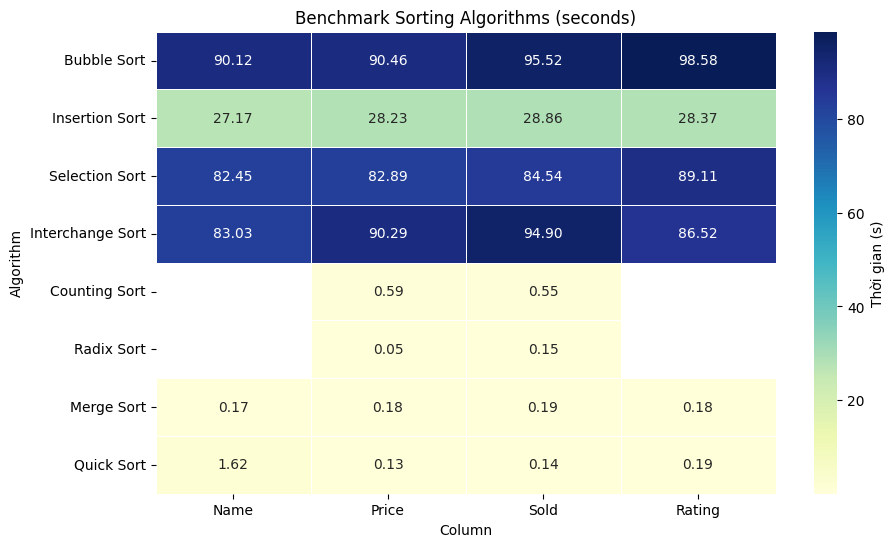

In [27]:
# Dataset từ kết quả benchmark
benchmark_results = [
    ("Bubble Sort", 90.12, 90.46, 95.52, 98.58),
    ("Insertion Sort", 27.17, 28.23, 28.86, 28.37),
    ("Selection Sort", 82.45, 82.89, 84.54, 89.11),
    ("Interchange Sort", 83.03, 90.29, 94.90, 86.52),
    ("Counting Sort", np.nan, 0.59, 0.55, np.nan),
    ("Radix Sort", np.nan, 0.05, 0.15, np.nan),
    ("Merge Sort", 0.17, 0.18, 0.19, 0.18),
    ("Quick Sort", 1.62, 0.13, 0.14, 0.19),
]

# Tạo DataFrame
benchmark_results = pd.DataFrame(benchmark_results, columns=["Algorithm", "Name", "Price", "Sold", "Rating"])
benchmark_results.set_index("Algorithm", inplace=True)

print(benchmark_results)

# Vẽ heatmap
plt.figure(figsize=(10,6))
sns.heatmap(benchmark_results, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Thời gian (s)'}, linewidths=.5)

plt.title("Benchmark Sorting Algorithms (seconds)")
plt.ylabel("Algorithm")
plt.xlabel("Column")
plt.show()


In [4]:
"-7".isdigit()

False

In [20]:
def is_operator(token: str) -> bool:
    return len(token) == 1 and token in "+-*/"

def is_valid_number(token: str) -> bool:
    if not token:
        return False
    if token[0] == '-' and len(token) > 1:
        return token[1:].isdigit()
    return token.isdigit()

def tokenize(expression: str) -> List[str]:
    tokens = []
    index = 0
    length = len(expression)
    
    while index < length:
        # Skip whitespace
        if expression[index].isspace():
            index += 1
            continue

        # Handle numbers (including negative numbers)
        if expression[index].isdigit() or (
            expression[index] == '-' 
            and index + 1 < length 
            and expression[index + 1].isdigit()
        ):
            number = ""
            if expression[index] == '-':
                number += '-'
                index += 1
            while index < length and expression[index].isdigit():
                number += expression[index]
                index += 1
            tokens.append(number)

        else:
            # Handle unary minus: e.g., "-x" or "(-5)"
            if expression[index] == '-':
                if not tokens or tokens[-1] == "(" or is_operator(tokens[-1]):
                    tokens.append("0")
                    tokens.append("-")
                    index += 1
                    continue

            # Default: treat as a single-character token (operator, parenthesis, etc.)
            tokens.append(expression[index])
            index += 1

    return tokens

def precedence(op: str) -> int:
    if op in "+-":
        return 1
    if op in "*/":
        return 2
    return 0

def infix_to_postfix(infix: str) -> str:
    tokens = tokenize(infix)
    stack = []
    output = []
    

    for t in tokens:
        if is_valid_number(t) or t.isidentifier():  # number or variable
            output.append(t)
        elif t == "(":
            stack.append(t)
        elif t == ")":
            while stack and stack[-1] != "(":
                output.append(stack.pop())
            if not stack:
                raise ValueError("Mismatched parentheses")
            stack.pop()  # remove '('
        elif is_operator(t):
            while (stack and is_operator(stack[-1]) and precedence(stack[-1]) >= precedence(t)):
                output.append(stack.pop())
            stack.append(t)
        else:
            raise ValueError(f"Invalid token: {t}")

    while stack:
        if stack[-1] in "()":
            raise ValueError("Mismatched parentheses")
        output.append(stack.pop())

    return " ".join(output)

def evaluate_postfix(postfix: str) -> int:
    stack = []
    tokens = postfix.split()
    
    for token in tokens:
        if is_valid_number(token):
            stack.append(int(token))
        elif is_operator(token):
            if len(stack) < 2:
                raise ValueError("Invalid postfix expression")
            b = stack.pop()
            a = stack.pop()
            if token == "+":
                res = a + b
            elif token == "-":
                res = a - b
            elif token == "*":
                res = a * b
            elif token == "/":
                if b == 0:
                    raise ValueError("Division by zero")
                res = a // b
            stack.append(res)
        else:
            raise ValueError(f"Invalid token in postfix: {token}")

    if len(stack) != 1:
        raise ValueError("Invalid postfix expression")
    return stack[0]

In [21]:
def run_tests():
    print("🧪 Bắt đầu kiểm thử...\n")

    # --- Test is_operator ---
    assert is_operator('+') == True
    assert is_operator('-') == True
    assert is_operator('**') == False
    assert is_operator('a') == False
    print("✅ is_operator: OK")

    # --- Test is_valid_number ---
    assert is_valid_number('123') == True
    assert is_valid_number('-456') == True
    assert is_valid_number('0') == True
    assert is_valid_number('') == False
    assert is_valid_number('-') == False
    assert is_valid_number('12a') == False
    print("✅ is_valid_number: OK")

    # --- Test tokenize ---
    assert tokenize("3 + 4 * 5") == ['3', '+', '4', '*', '5']
    assert tokenize("-5") == ['0', '-', '5']
    assert tokenize("(-x)") == ['(', '0', '-', 'x', ')']
    assert tokenize("a1_b2") == ['a1_b2']  # isidentifier() cho phép
    print("✅ tokenize: OK")

    # --- Test infix_to_postfix ---
    assert infix_to_postfix("3+4*5") == "3 4 5 * +"
    assert infix_to_postfix("(3+4)*5") == "3 4 + 5 *"
    assert infix_to_postfix("-5") == "0 5 -"
    assert infix_to_postfix("3+-4") == "3 0 4 - +"
    print("✅ infix_to_postfix: OK")

    # --- Test evaluate_postfix ---
    assert evaluate_postfix("3 4 5 * +") == 23
    assert evaluate_postfix("0 5 -") == -5
    assert evaluate_postfix("10 2 /") == 5
    print("✅ evaluate_postfix: OK")

    # --- Test end-to-end ---
    expr = "2 * (3 + -4)"
    postfix = infix_to_postfix(expr)
    result = evaluate_postfix(postfix)
    assert result == -2  # 2 * (3 + (-4)) = 2 * (-1) = -2
    print("✅ End-to-end test: OK")

    print("\n🎉 Tất cả test đều PASSED!")
    
# Chạy test
run_tests()

🧪 Bắt đầu kiểm thử...

✅ is_operator: OK
✅ is_valid_number: OK


AssertionError: 

In [18]:
tokenize("-5")

['-5']

In [19]:
tokenize("(-x)")

['(', '0', '-', 'x', ')']